In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 安裝gymnassium套件

In [ ]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379439 sha256=60566c926d34b4b364b9c3a70f64a4938e87cf26f52989ca52e27a05bd535221
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


# import 必要套件

In [ ]:
import random
import time,math
import numpy as np
import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import matplotlib.pyplot as plt
import matplotlib.animation as animation #輸出動畫影片
import matplotlib.font_manager as plt_font
twfont1=plt_font.FontProperties(fname="/content/drive/MyDrive/解密AI黑盒子分享/字型/kaiu.ttf")
from IPython import display
from tqdm import tqdm

In [ ]:
import torch
import torch.nn.functional as F
import collections
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ImageEnv(gym.Wrapper):
  def __init__(self,env,stack_frames=4,delay_op=50):
    super(ImageEnv, self).__init__(env)
    self.delay_op = delay_op
    self.stack_frames = stack_frames
  def reset(self):
    s, info = self.env.reset()
    for i in range(self.delay_op):
      s, r, terminated, truncated, info = self.env.step(0)
      s=s[:84, 6:90]/255.0
      self.stacked_state = np.tile( s , (self.stack_frames,1,1) )  # [4, 84, 84]
    return self.stacked_state, info

  def step(self, action):
    reward = 0
    for _ in range(self.stack_frames):
      s, r, terminated, truncated, info = self.env.step(action)
      if r==-100:terminated=True
      s=s[:84, 6:90]/255.0
      reward += r
      if terminated or truncated:break
      self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)
    return self.stacked_state, reward, terminated, truncated, info

# 建立Replay Buffer類別

In [ ]:
class ReplayBuffer:
  def __init__(self,max_size=int(1e5), num_steps=1):
    self.s = np.zeros((max_size,4,84,84), dtype=np.float32)
    self.a = np.zeros((max_size,), dtype=np.int64)
    self.r = np.zeros((max_size, 1), dtype=np.float32)
    self.s_ = np.zeros((max_size,4,84,84), dtype=np.float32)
    self.done = np.zeros((max_size, 1), dtype=np.float32)
    self.ptr = 0
    self.size = 0
    self.max_size = max_size
    self.num_steps = num_steps

  def append(self,s,a,r,s_,done):
    self.s[self.ptr] = s
    self.a[self.ptr] = a
    self.r[self.ptr] = r
    self.s_[self.ptr] = s_
    self.done[self.ptr] = done
    self.ptr = (self.ptr + 1) % self.max_size
    self.size = min(self.size+1,self.max_size)
  def sample(self, batch_size):
    ind = np.random.randint(0, self.size, batch_size)
    return torch.FloatTensor(self.s[ind]),torch.LongTensor(self.a[ind]),torch.FloatTensor(self.r[ind]),torch.FloatTensor(self.s_[ind]),torch.FloatTensor(self.done[ind])

# 搭建DQN神經網路的類別

In [ ]:
class DQN(torch.nn.Module):
  def __init__(self,n_act):
    super(DQN,self).__init__()
    self.conv1 = torch.nn.Conv2d(4, 32, kernel_size=8, stride=4)  #[N,4,84,84]->[N,32,20,20]
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)  #[N,32,20,20]->[N,64,9,9]
    self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)  #[N,64,9,9]->[N,64,7,7]
    self.fc1 = torch.nn.Linear(64 * 7 * 7, 512)
    self.fc2 = torch.nn.Linear(512, n_act)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view((-1, 64 * 7 * 7))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# 設定是否載入模型參數，舊參數檔路徑，新參數檔路徑

In [ ]:
Load_File=840
folder="/content/drive/MyDrive/強化學習期末專題(小組)/NatureDQN/model/"
Old_File=folder+f"model_NatureDQN-{Load_File}.pt"
if Load_File>0:
  Log= np.load(folder+f"Log_NatureDQN-{Load_File}.npy", allow_pickle=True).item()
else:
  Log={"TrainReward":[],"TestReward":[],"Loss":[]} # 確認模型如何變好

In [ ]:
env=gym.make('CarRacing-v3',render_mode="rgb_array",domain_randomize=False, continuous=False)
env = gym_wrap.GrayscaleObservation(env)
env = ImageEnv(env)

# 搭建智能體Agent的類別

In [ ]:
class DQNAgent():
  def __init__(self,gamma=0.9,eps_low=0.1,lr=0.001):
    self.env=env
    self.n_act=self.env.action_space.n
    self.PredictDQN= DQN(self.n_act)
    self.TargetDQN= DQN(self.n_act)
    if Load_File>0:
      self.PredictDQN.load_state_dict(torch.load(Old_File))
      self.TargetDQN.load_state_dict(torch.load(Old_File))
    self.PredictDQN.to(device)
    self.TargetDQN.to(device)
    self.LossFun=torch.nn.MSELoss()   # Nature DQN 的損失函數改用 MSELoss()
    self.optimizer=torch.optim.Adam(self.PredictDQN.parameters(),lr=lr)
    self.gamma=gamma
    self.eps_low=eps_low
    self.rb=ReplayBuffer(max_size=2000, num_steps=4)
  def PredictA(self,s):
    with torch.no_grad():
      return torch.argmax(self.PredictDQN(torch.FloatTensor(s).to(device))).item()
  def SelectA(self,a):
    return self.env.action_space.sample() if np.random.random()<self.EPS else a
  def Train(self,N_EPISODES):
    for i in tqdm(range(Load_File,N_EPISODES)):
      self.EPS=self.eps_low+(1-self.eps_low)*math.exp(-i*5/(N_EPISODES))
      total_reward=0
      s,_=self.env.reset()
      while True:
        a=self.SelectA(self.PredictA(s))
        s_,r,done,stop,_=self.env.step(a)
        self.rb.append(s,a,r,s_,done)
        if self.rb.size > 200 and i%4==0: self.Learn()
        if i % 20==0:  self.TargetDQN.load_state_dict(self.PredictDQN.state_dict())
        s=s_
        total_reward+=r
        if done or stop:break
      Log["TrainReward"].append(total_reward)
      if i % 10 == 9:
        test_reward=self.Test()
        print(f"\n訓練次數{i+1}，總回報{test_reward}")
        Log["TestReward"].append(test_reward)
        torch.save(self.PredictDQN.state_dict(), f"{folder}/model_NatureDQN-{i+1}.pt")
        np.save(f"{folder}/Log_NatureDQN-{i+1}.npy", Log)
  def Learn(self):
    self.optimizer.zero_grad()
    batch_s,batch_a,batch_r,batch_s_,batch_done=self.rb.sample(32)
    predict_Q=(self.PredictDQN(batch_s.to(device))*F.one_hot(batch_a.long().to(device),self.n_act)).sum(1,keepdims=True)
    with torch.no_grad():
      next_act=self.PredictDQN(batch_s_.to(device)).argmax(1,keepdims=True)
      target_Q_values=self.TargetDQN(batch_s_.to(device)).gather(1,next_act)
      target_Q=batch_r.to(device)+(1-batch_done.to(device))*self.gamma*target_Q_values
    loss=self.LossFun(predict_Q,target_Q)
    Log["Loss"].append(float(loss))
    loss.backward()
    self.optimizer.step()
  def Test(self,VIDEO=False):
    total_reward=0
    video=[]
    s,_=self.env.reset()
    while True:
      video.append(self.env.render())
      a=self.PredictA(s)
      s,r,done,stop,_=self.env.step(a)
      total_reward+=r
      if done or stop:break
    if VIDEO:
      patch = plt.imshow(video[0]) #產生展示圖形物件
      plt.axis('off') #關閉坐標軸
      def animate(i): #設定更換影格的函數
        patch.set_data(video[i])
        #plt.gcf()=>建新繪圖區 animate=>更換影格函數 frames=>影格數 interval=>影隔間距(毫秒)
      anim = animation.FuncAnimation(plt.gcf(),animate,frames=len(video),interval=200)
      anim.save('Car_racing.mp4') #儲存為mp4擋
    return total_reward

# 實體化智能體Agent，開始訓練智能體

In [ ]:
Agent=DQNAgent(gamma=0.95,eps_low=0.05,lr=0.00025)
Agent.Train(N_EPISODES=1000)

<ipython-input-10-799dd2caeb4c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.PredictDQN.load_state_dict(torch.load(Old_File))
<ipython-input-10-799dd2caeb4c>:9: Fut


訓練次數850，總回報189.3750000000045


 12%|█▎        | 20/160 [03:57<33:36, 14.40s/it]


訓練次數860，總回報779.9999999999861


 19%|█▉        | 30/160 [05:56<31:52, 14.71s/it]


訓練次數870，總回報-11.376306620209306


 25%|██▌       | 40/160 [07:54<28:14, 14.12s/it]


訓練次數880，總回報-94.99999999999906


 31%|███▏      | 50/160 [09:52<26:35, 14.51s/it]


訓練次數890，總回報626.1538461538382


 38%|███▊      | 60/160 [11:50<23:50, 14.30s/it]


訓練次數900，總回報-94.99999999999895


 44%|████▍     | 70/160 [13:50<22:03, 14.71s/it]


訓練次數910，總回報185.82191780822336


 50%|█████     | 80/160 [15:46<18:54, 14.18s/it]


訓練次數920，總回報-94.99999999999903


 56%|█████▋    | 90/160 [17:47<16:50, 14.44s/it]


訓練次數930，總回報-94.999999999999


 62%|██████▎   | 100/160 [19:45<14:19, 14.32s/it]


訓練次數940，總回報408.49650349649414


 69%|██████▉   | 110/160 [21:45<12:20, 14.82s/it]


訓練次數950，總回報617.2302158273257


 75%|███████▌  | 120/160 [23:42<09:21, 14.04s/it]


訓練次數960，總回報-94.99999999999895


 81%|████████▏ | 130/160 [25:38<07:26, 14.88s/it]


訓練次數970，總回報139.43223443223877


 88%|████████▊ | 140/160 [27:38<04:56, 14.80s/it]


訓練次數980，總回報425.91254752851256


 94%|█████████▍| 150/160 [29:36<02:24, 14.44s/it]


訓練次數990，總回報350.6521739130417


100%|██████████| 160/160 [31:33<00:00, 11.84s/it]


訓練次數1000，總回報588.6734693877468


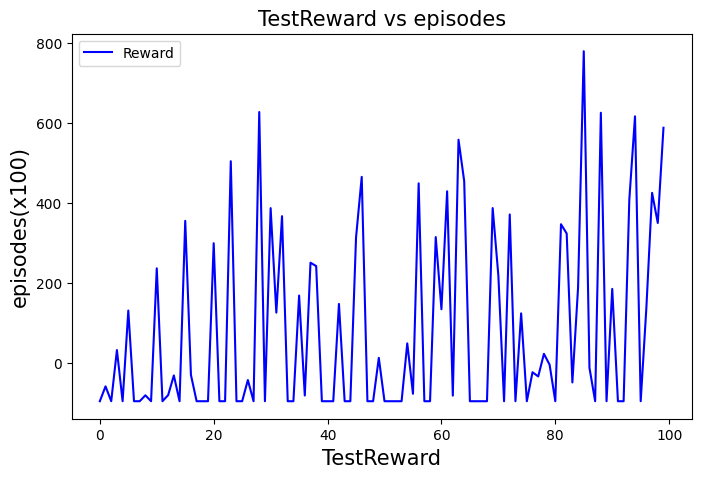

In [ ]:
plt.figure(figsize=(8,5)) #設定繪圖區大小
#繪圖區的標題，設定用中文字體twfont1，字體大小15
plt.title("TestReward vs episodes",fontsize=15)
#設定橫軸和縱軸的標題
plt.xlabel("TestReward",fontsize=15)
plt.ylabel("episodes(x100)",fontsize=15)
plt.plot(Log["TestReward"],"b-",label="Reward")
plt.legend()

## 測試智能體平均表現


## 生成智能體Agent測試影片

482.28706624604325

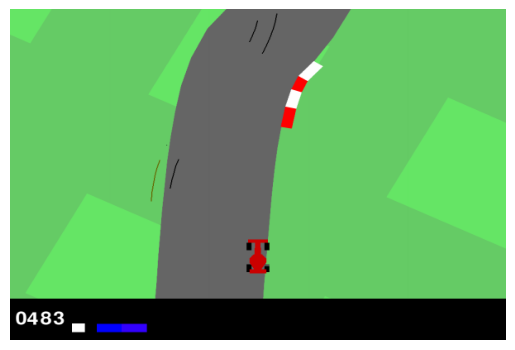

In [ ]:
Agent.Test(VIDEO=True)